In [ ]:
!pip install pysam

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pysam
vcf = pysam.VariantFile('/content/drive/MyDrive/experiment_23.vcf');
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

1.Koliko je subjekata ukupno učestvovalo u studiji? Koliko njih su oboleli, a koliko zdravi?

In [4]:
caSe = 0;
control = 0;

for sub in vcf.header.samples:
  if ('case' in sub):
     caSe+=1
  else:
    control+=1
print(f"Ukupno je ucestovalo {caSe+control} subjekata. Obolelih je {caSe}, a zdravih {control}.")

Ukupno je ucestovalo 200 subjekata. Obolelih je 100, a zdravih 100.


2. Koliko je ukupno mutacija posmatrano u populaciji? Dati tabelu sa brojem mutacija po hromozomu.

In [5]:
cnt = 0;
dictionary = dict()
for var in vcf.fetch():
  if (var.chrom in dictionary):
    dictionary[var.chrom]+=1
  else:
    dictionary[var.chrom] = 1
  cnt+=1
print(f"Ukupno je posmatrano {cnt} mutacija.")
print(f"  CHROM\t: NUMBER OF MUTATIONS")
for key in dictionary.keys():
  print(f"  {key}\t:\t{dictionary[key]}")

Ukupno je posmatrano 1340824 mutacija.
  CHROM	: NUMBER OF MUTATIONS
  1	:	102842
  2	:	114870
  3	:	92888
  4	:	85336
  5	:	86532
  6	:	95476
  7	:	74003
  8	:	76756
  9	:	65374
  10	:	72903
  11	:	67554
  12	:	66884
  13	:	56428
  14	:	44790
  15	:	38680
  16	:	37876
  17	:	30975
  18	:	41882
  19	:	19172
  20	:	33382
  21	:	18402
  22	:	17819


3. Nacrtati sledeće histograme, pri čemu odvojeno prikazati podatke dobijene iz zdravih i obolelih pacijenata (po dva histograma na istom grafiku):

3a. Frekvencije ređih alela (minor allele frequency, MAF) za svaku mutaciju u studiji

3b. Procenat homozigotnih referentnih uzoraka za svaku od mutacija u studiji

3c. Procenat homozigotnih alternativnih uzoraka za svaku od mutacija u studiji

3d. Procenat heterozigotnih uzoraka za svaku od mutacija u studiji



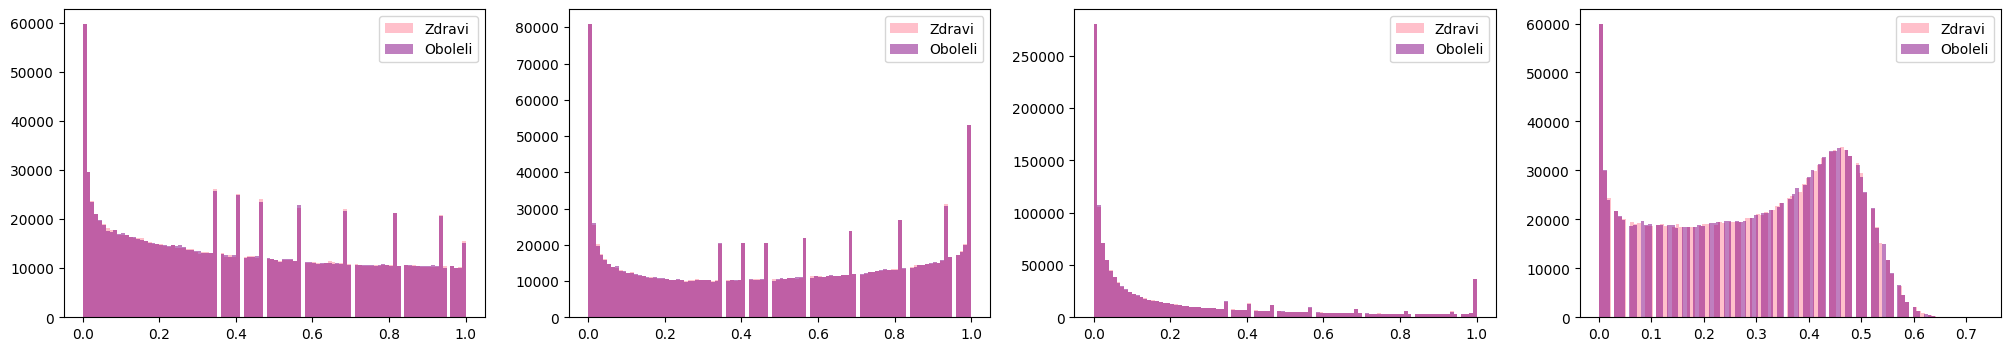

In [6]:
caSeHomo =[]
controlHomo = []
caSeAlt =[]
controlAlt = []
caSeHet =[]
controlHet = []
caSeMAF =[]
controlMAF = []
#cnt = 0

for var in vcf.fetch():
  #cnt+=1
  caSeHomoCnt = 0
  controlHomoCnt = 0
  caSeAlNull = 0
  caSeAlOne = 0
  controlAlNull = 0
  controlAlOne = 0
  caSeHetCnt = 0
  controlHetCnt = 0
  caSeAltCnt = 0
  controlAltCnt = 0

  for sub in var.samples:
    data = var.samples[sub]
    #print(f"{var}: {sub}: {data['GT'][0]},{data['GT'][1]}\n")
    if ('case' in sub):
      if (data['GT'][0]==0):
        caSeAlNull+=1
        if (data['GT'][1]==0):
          caSeAlNull+=1
          caSeHomoCnt+=1
        else:
          caSeAlOne+=1
          caSeHetCnt+=1
      else:
        caSeAlOne+=1
        if (data['GT'][1]==1):
          caSeAlOne+=1
          caSeAltCnt+=1
        else:
          caSeAlNull+=1
          caSeHetCnt+=1
    else:
      if (data['GT'][0]==0):
        controlAlNull+=1
        if (data['GT'][1]==0):
          controlAlNull+=1
          controlHomoCnt+=1
        else:
          controlAlOne+=1
          controlHetCnt+=1
      else:
        controlAlOne+=1
        if (data['GT'][1]==1):
          controlAlOne+=1
          controlAltCnt+=1
        else:
          controlAlNull+=1
          controlHetCnt+=1

  caSeMin = min(caSeAlNull, caSeAlOne)
  caSeMAF.append(caSeMin/100)
  controlMin = min(controlAlNull, controlAlOne)
  controlMAF.append(controlMin/100)
  caSeHomo.append(caSeHomoCnt/100)
  controlHomo.append(controlHomoCnt/100)
  caSeAlt.append(caSeAltCnt/100)
  controlAlt.append(controlAltCnt/100)
  caSeHet.append(caSeHetCnt/100)
  controlHet.append(controlHetCnt/100)

#   if cnt>10000:
#     break

oboleli = []
oboleli.append(caSeMAF)
oboleli.append(caSeHomo)
oboleli.append(caSeAlt)
oboleli.append(caSeHet)
zdravi = []
zdravi.append(controlMAF)
zdravi.append(controlHomo)
zdravi.append(controlAlt)
zdravi.append(controlHet)

fig = plt.figure(figsize=(25, 4))

for i in range(4):
  #print(f"{oboleli[i]}\n{zdravi[i]}")
  ax = fig.add_subplot(1,4,i+1)
  ax.hist(zdravi[i], alpha=1, label='Zdravi', bins=100, color='pink')
  ax.hist(oboleli[i], alpha=0.5, label='Oboleli', bins=100, color='purple')
  ax.legend()

4. Identifikovati mutacije koje su statistički značajno asocirane sa datom bolešću (p manje od 0.05, upotrebom hi kvadrat testa).

4a. Primeniti hi kvadrat test na sve mutacije u studiji

4b. Da li je potrebno izvršiti korekciju za višestruko testiranje (odgovor dati napismeno)? Ukoliko jeste, objasniti kako, i primeniti je.

4c. Nacrtati Menhetn grafikon. Voditi računa da su ose adekvatno anotirane i da dužina duž X ose alocirana svakom hromozomu bude proporcionalna dužini hromozoma.

4d. Za svaku mutaciju koja je statistički značajno asocirana sa datom bolešću odrediti da li odstupa od Hardi-Vajnberg ekvilibrijuma (upotrebom hi kvadrat testa). Da li ima takvih mutacija? Da li je ovom prilikom potrebna korekcija za višestruko testiranje (obrazložiti)?

4b. Posto testiranje vrsimo na ogromnom uzorku i vrsimo ga mnogo puta korekcija je potrebna. Najjednostavnije rešenje za problem višestrukog testiranja je Bonferoni korekcija koja predlaže da se p vrednost pomnoži brojem eksperimenata (odnosno da se granica za odbacivanje nulte hipoteze podeli za brojem eksperimenata).

4d. Nije potrebna korekcija.

In [ ]:
cnt=0
pvals = []
allPs = []
hw_deviation_mutations = []
print("Statistički značajne mutacije:" )
for var in vcf.fetch():
  cnt+=1
  caSeHomoCnt = 1
  controlHomoCnt = 1
  caSeHetCnt = 1
  controlHetCnt = 1
  caSeAltCnt = 1
  controlAltCnt = 1
  for sub in var.samples:
    data = var.samples[sub]
    if ('case' in sub):
      if (data['GT'][0] == data['GT'][1]):
        if (data['GT'][0]==0):
          caSeHomoCnt +=1
        else:
          caSeAltCnt +=1
      else:
        caSeHetCnt +=1
    else:
      if (data['GT'][0] == data['GT'][1]):
        if (data['GT'][0]==0):
          controlHomoCnt +=1
        else:
          controlAltCnt +=1
      else:
        controlHetCnt +=1
  observations = [[caSeHomoCnt, caSeHetCnt, caSeAltCnt], [controlHomoCnt, controlHetCnt, controlAltCnt]]

  chi2_stat, p_val, dof, expected = chi2_contingency(observations)
  allPs.append(p_val);
  if (p_val<0.05/cnt):
    print(f"{var.chrom}-{var.pos} : {p_val}")
    pvals.append(p_val)
    het = caSeHetCnt+controlHetCnt
    homo = caSeHomoCnt+controlHomoCnt
    alt = caSeAltCnt+controlAltCnt

    p = homo/200
    q = alt/200
    pq2 = het/200

    observed2 = [[(caSeHomoCnt+controlHomoCnt), (caSeHetCnt + controlHetCnt) , (caSeAltCnt + controlAltCnt)], [p, q, pq2]]
    chi2_hw, p_value2, dof, expected  = chi2_contingency(observed2)
    if p_value2 < 0.05:
        hw_deviation_mutations.append((var.chrom, var.pos))
    else:
        print(f"Mutacija na hromozomu: {var.chrom} ne odstupa od HWE")


In [12]:
min_value = min(pvals)

print("Minimum value in the array:", min_value)
#7-142577998 : 2.62208934010697e-18

Minimum value in the array: 2.62208934010697e-18


In [ ]:
!pip install qmplot

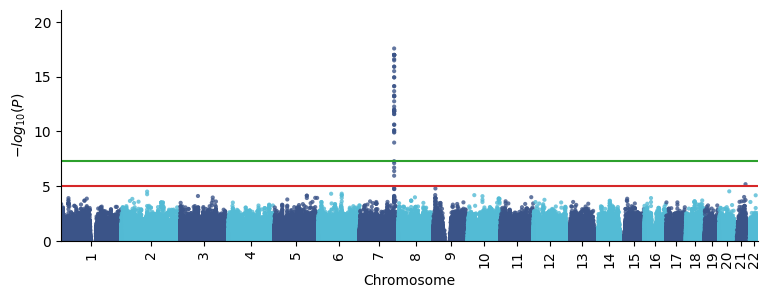

In [ ]:
import pandas as pd
from qmplot import manhattanplot

positions = []
chromosomes = []
for var in vcf.fetch():
    positions.append(var.pos)
    chromosomes.append(var.chrom)

data = {
    '#CHROM': chromosomes,
    'POS': positions,
    'P': allPs
}

df = pd.DataFrame(data)

ax = manhattanplot(data=df, xticklabel_kws={"rotation": "vertical"})
plt.show()

5. Na osnovu mutacije koja pokazuje najjaču asocijaciju sa bolešću odrediti region na referentnom genomu gde se verovatno nalazi gen koji uzrokuje bolest.

5a. Identifikovati jedan ili više mogućih gena upotrebom UCSC Genome browsera. Studija je rađena prema GRCH37 referentnom genomu.
# u pitanju je gen TRPV6
https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg19&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr7%3A142572998%2D142582997&hgsid=2091134176_FtSPcMq7pWMha9GQEppJANbZa5wN



5b. Izvući podatke o bolestima vezanim za identifikovane gene sa OMIM sajta (nije potrebno prevoditi na srpski jezik).
**TRANSIENT RECEPTOR POTENTIAL CATION CHANNEL, SUBFAMILY V, MEMBER 6; TRPV6**
*Calcium-permeable channels, such as TRPV6, participate in neurotransmission, muscle contraction, and exocytosis by providing calcium as an intracellular second messenger. Depending on the tissue, transcellular calcium transport may be regulated by vitamin D, parathyroid hormone (PTH; 168450), or calcitonin (CALCA; 114130).*